In [ ]:
!pip install transformers
!pip install sentencepiece

import pandas as pd
import numpy as np
import sentencepiece as spm
import numpy as np
import time
import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import XLNetTokenizer, XLNetModel
from transformers import XLNetForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

     |████████████████████████████████| 2.3MB 2.9MB/s 
     |████████████████████████████████| 3.3MB 17.2MB/s 
     |████████████████████████████████| 901kB 26.8MB/s 
     |████████████████████████████████| 1.2MB 3.0MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Skripsi/datatrainFinal.csv", sep=',', header=None)
df = df.rename(columns={0: 'content', 1: 'category'})
df.head(10)

,content,category
0,KOMPAS.com - Liverpool dan Manchester United...,Bola
1,KOMPAS.com - Steven Gerrard adalah legenda L...,Bola
2,KOMPAS.com - Pelatih asal Portugal yang kini m...,Bola
3,KOMPAS.com - Lupakan duel Alessandro Nesta ver...,Bola
4,"KOMPAS.com - Bek senior andalan Lazio, Stefa...",Bola
5,"KOMPAS.com - Pelatih tim nasional Indonesia, ...",Bola
6,KOMPAS.com - Terdapat kutukan yang tak kunjung...,Bola
7,KOMPAS.com - Real Madrid gagal melaju ke fina...,Bola
8,KOMPAS.com - Liverpool dan Manchester United...,Bola
9,KOMPAS.com - Steven Gerrard adalah legenda L...,Bola


In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/Skripsi/datatestFinal.csv", sep=',', header=None)
df_test = df_test.rename(columns={0: 'content', 1: 'category'})
df_test.head(10)

,content,category
0,"KOMPAS.com - Pelatih Chelsea, Thomas Tuchel, m...",Bola
1,KOMPAS.com - Bayern Muenchen menderita kekalah...,Bola
2,KOMPAS.com - Kylian Mbappe menjadi aktor utama...,Bola
3,KOMPAS.com - Chelsea tampil sangat impresif ke...,Bola
4,KOMPAS.com - Kylian Mbappe mulai mengancam Erl...,Bola
5,KOMPAS.com - Paris Saint-Germain (PSG) dan Che...,Bola
6,KOMPAS.com - Paris Saint-Germain (PSG) mengema...,Bola
7,KOMPAS.com - Chelsea berada di ambang pimtu se...,Bola
8,KOMPAS.com - Juventus menang 2-1 atas Napoli p...,Bola
9,KOMPAS.com - Chelsea akan bertindak sebagai ti...,Bola


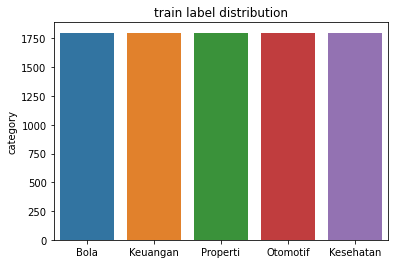

In [ ]:
df_plot = sns.barplot(y = df['category'].value_counts(), x = df['category'].value_counts().index).set_title('train label distribution')
df_plot.get_figure().savefig('df_dist.png')

In [ ]:
def categoryToLabel(category):
    if category == 'Bola':
        return 0
    elif category == 'Kesehatan':
        return 1
    elif category == 'Keuangan':
        return 2
    elif category == 'Otomotif':
        return 3
    elif category == 'Properti':
        return 4
    else :
        return false

In [ ]:
df['category'] = df['category'].apply(categoryToLabel)
df_test['category'] = df_test['category'].apply(categoryToLabel)

In [ ]:
contents = df.content.values
labels = df.category.values  

contents_test = df_test.content.values
labels_test = df_test.category.values 

In [ ]:
!pip install sentencepiece
import sentencepiece as spm

In [ ]:
from transformers import XLNetTokenizer, XLNetModel
tokenizer = XLNetTokenizer.from_pretrained('huseinzol05/xlnet-base-bahasa-cased', do_lower_case = True)

In [ ]:
text = "Lupakan Premier League, Liverpool Kini Fokus Dapatkan Trofi Liga Champion"
token = tokenizer.tokenize(text)
token_ids = tokenizer.convert_tokens_to_ids(token)
token_encode = tokenizer.encode(text, add_special_tokens = True)
token_decode = tokenizer.decode(token_encode)

print("Original : ", text)
print("Token : ", token)
print("Token Ids: ", token_ids)
print("Token Encode: ", token_encode)
print("Token Decode: ", token_decode)


Original :  Lupakan Premier League, Liverpool Kini Fokus Dapatkan Trofi Liga Champion
Token :  ['▁lupakan', '▁', 'premier', '▁', 'league', ',', '▁liverpool', '▁kini', '▁fokus', '▁dapatkan', '▁trofi', '▁liga', '▁champion']
Token Ids:  [8559, 19, 26419, 19, 17980, 21, 13445, 646, 2127, 2142, 23659, 5481, 15587]
Token Encode:  [8559, 19, 26419, 19, 17980, 21, 13445, 646, 2127, 2142, 23659, 5481, 15587, 4, 3]
Token Decode:  lupakan premier league, liverpool kini fokus dapatkan trofi liga champion<sep><cls>


In [ ]:
input_ids = []

for sent in contents:
  encoded_sent = tokenizer.encode_plus(sent, add_special_tokens=True, max_length=512, return_tensors='pt', 
                                       return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=True)
  input_ids.append(encoded_sent)

print("Original: ", contents[0])
print("Token IDs: ", input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  KOMPAS.com -  Liverpool dan  Manchester United bentrok pada pekan ke-19  Liga Inggris 2020-2021.
Laga Liverpool vs  Man United akan dilangsungkan di Stadion Anfield, Minggu (17/1/2021) pukul 23.30 WIB.
Duel kedua tim menjadi yang paling dinantikan pada akhir pekan ini sebab Manchester United dan Liverpool sedang bersaing untuk menduduki puncak klasemen Liga Inggris 2020-2021.
Man United untuk sementara memuncaki klasemen dengan mengumpulkan 36 poin dari 17 pertandingan.
Baca juga: Liverpool Vs Man United, Laga Besar yang Bisa Hentikan Rekor Menawan
Sementara itu, Liverpool menyusul di peringkat kedua dan meraih 33 poin dari jumlah laga yang sama.
Tak sedikit yang menduga laga ini akan menjadi penentu jalannya persaingan juara Liga Inggris.
Artinya, siapa pun yang memenangi pertandingan ini dianggap bakal unggul dan menjadi juara pada akhir musim ini.
Meski demikian, gelandang Manchester United,  Paul Pogba, enggan membesar-besarkan pertandingan kontra Liverpool.
Di mata Pogb

In [ ]:
input_ids_test = []

for sent in contents_test:
  encoded_sent = tokenizer.encode_plus(sent, add_special_tokens=True, max_length=512, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=True)
  input_ids_test.append(encoded_sent)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print(input_ids[1]["input_ids"])

tensor([[    5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,  9651,
           874,     9,  1164,    19,    13,    19,  4002,  3015,    19,  1966,
           151,  4467,    74, 16751, 13445,     9,  

In [ ]:
inputs_ids, attention_mask = [],[]
for item in input_ids:
  for key in item:
    if(key == "input_ids"):
      inputs_ids.append((item[key]).numpy().tolist())
    elif(key == "attention_mask"):
      attention_mask.append((item[key]).numpy().tolist())

In [ ]:
inputs_ids_test, attention_mask_test = [],[]

for item in input_ids_test:
  for key in item:
    if(key == "input_ids"):
      inputs_ids_test.append((item[key]).numpy().tolist())
    elif(key == "attention_mask"):
      attention_mask_test.append((item[key]).numpy().tolist())

In [ ]:
inputs_ids = [item for sublist in inputs_ids for item in sublist]
attention_mask = [item for sublist in attention_mask for item in sublist]

inputs_ids_test = [item for sublist in inputs_ids_test for item in sublist]
attention_mask_test = [item for sublist in attention_mask_test for item in sublist]

In [ ]:
from sklearn.model_selection import train_test_split

train_input, validation_input, train_labels, validation_labels = train_test_split(inputs_ids,
                                                                      labels,
                                                                      random_state=2017,
                                                                      test_size=0.15)
train_mask, validation_mask, _, _  = train_test_split(attention_mask,
                                               labels,
                                               random_state=2017,
                                               test_size=0.15)

test_input = inputs_ids_test
test_mask = attention_mask_test
test_labels = labels_test

In [ ]:
print(np.shape(train_input))

(7650, 512)


In [ ]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 8

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [ ]:
from transformers import XLNetForSequenceClassification

model = XLNetForSequenceClassification.from_pretrained('huseinzol05/xlnet-base-bahasa-cased', num_labels = 5)
CUDA_LAUNCH_BLOCKING=1
model = model.to(device)

model.cuda()

Some weights of the model checkpoint at huseinzol05/xlnet-base-bahasa-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at huseinzol05/xlnet-base-bahasa-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task 

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:
params = list(model.named_parameters())

print("The XLNet model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))


The XLNet model has 210 different named parameters.
==== Embedding Layer ====
transformer.mask_emb                                          (1, 1, 768)
transformer.word_embedding.weight                            (32000, 768)
transformer.layer.0.rel_attn.q                               (768, 12, 64)
transformer.layer.0.rel_attn.k                               (768, 12, 64)
transformer.layer.0.rel_attn.v                               (768, 12, 64)
transformer.layer.0.rel_attn.o                               (768, 12, 64)
transformer.layer.0.rel_attn.r                               (768, 12, 64)
transformer.layer.0.rel_attn.r_r_bias                            (12, 64)
transformer.layer.0.rel_attn.r_s_bias                            (12, 64)
transformer.layer.0.rel_attn.r_w_bias                            (12, 64)
transformer.layer.0.rel_attn.seg_embed                        (2, 12, 64)
transformer.layer.0.rel_attn.layer_norm.weight                     (768,)
transformer.layer.0.rel_attn.

In [ ]:
from transformers import  AdamW

#lr = 0.0005
optimizer = torch.optim.Adamax(
    model.parameters(),
    lr = 1e-4
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 7

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

train_loss_values = []
train_acc_values = []
eval_loss_values = []
eval_acc_values = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0
  train_accuracy = 0

  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):
    
    # Progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
    
    loss = outputs[0]
    total_loss += loss.item()

    loss.backward()

    logits = outputs[1]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_train_accuracy = flat_accuracy(logits, label_ids)
    train_accuracy += tmp_train_accuracy

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

  train_loss = total_loss / len(train_dataloader)
  train_loss_values.append(train_loss)
  train_acc = train_accuracy / len(train_dataloader)
  train_acc_values.append(train_acc)

  print("   Training loss : {0:.5f}".format(train_loss))
  print("   Training acc  : {0:.5f}".format(train_acc))
  print("   Training took : {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  e_loss = 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
      loss = outputs[0]
      e_loss += loss.item()

      logits = outputs[1]
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      tmp_eval_accuracy = flat_accuracy(logits, label_ids)
      eval_accuracy += tmp_eval_accuracy
  
  eval_loss = total_loss / len(validation_dataloader)
  eval_loss_values.append(eval_loss)
  eval_acc = eval_accuracy / len(validation_dataloader)
  eval_acc_values.append(eval_acc)

  print("   Validation loss : {0:.5f}".format(eval_loss))
  print("   Validation acc  : {0:.5f}".format(eval_acc))
  print("   Validation took : {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 7 =======
Training...
Batch    40 of   957.     Elapsed: 0:01:01
Batch    80 of   957.     Elapsed: 0:02:04
Batch   120 of   957.     Elapsed: 0:03:09
Batch   160 of   957.     Elapsed: 0:04:13
Batch   200 of   957.     Elapsed: 0:05:18
Batch   240 of   957.     Elapsed: 0:06:22
Batch   280 of   957.     Elapsed: 0:07:27
Batch   320 of   957.     Elapsed: 0:08:31
Batch   360 of   957.     Elapsed: 0:09:36
Batch   400 of   957.     Elapsed: 0:10:41
Batch   440 of   957.     Elapsed: 0:11:45
Batch   480 of   957.     Elapsed: 0:12:49
Batch   520 of   957.     Elapsed: 0:13:54
Batch   560 of   957.     Elapsed: 0:14:59
Batch   600 of   957.     Elapsed: 0:16:03
Batch   640 of   957.     Elapsed: 0:17:08
Batch   680 of   957.     Elapsed: 0:18:12
Batch   720 of   957.     Elapsed: 0:19:17
Batch   760 of   957.     Elapsed: 0:20:21
Batch   800 of   957.     Elapsed: 0:21:26
Batch   840 of   957.     Elapsed: 0:22:30
Batch   880 of   957.     Elapsed: 0:23:35
Batch   920 of

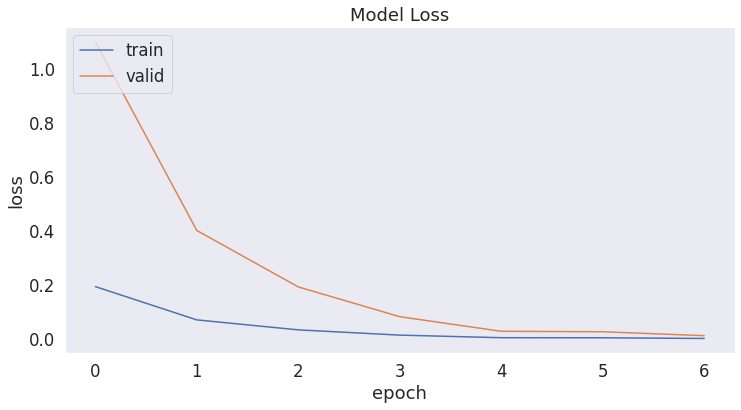

In [ ]:
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(train_loss_values)
plt.plot(eval_loss_values)
plt.title('Model Loss')
plt.grid(b=None)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

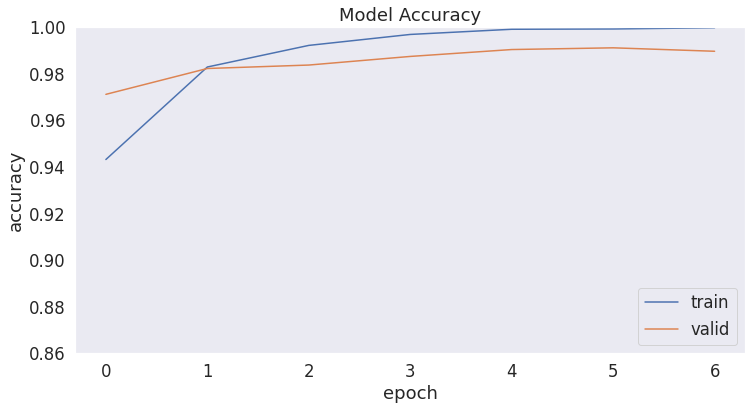

In [ ]:
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(train_acc_values)
plt.plot(eval_acc_values)
plt.title('Model Accuracy')
plt.ylim(0.86, 1)
plt.grid(b=None)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Skripsi/model_skripsiAdamaxBaru.model')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Skripsi/model_skripsiAdamaxBaru.model'))
model = model.to(device)

In [ ]:
import torch.nn.functional as F
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0].cpu().detach()
  
  probs = torch.argmax(outputs[0],dim=1).detach().cpu().numpy()

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  print(logits)
  print(probs)
  print(label_ids)
  print("\n\n")

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 1,000 test sentences
[[10.957825  -2.4541318 -2.9742422 -2.890638  -2.6488693]
 [10.9655    -2.3399236 -3.4195297 -2.7450912 -2.0420513]
 [10.981433  -2.379345  -3.1826155 -2.8888814 -2.3267035]
 [10.971954  -2.43513   -3.294279  -2.7821085 -2.2160926]
 [10.932656  -2.5225813 -3.0966008 -2.7816563 -2.4532592]
 [10.939508  -2.3781703 -3.412097  -2.77497   -1.8906641]
 [10.961586  -2.3563418 -3.3543167 -2.8027174 -2.0926776]
 [10.980452  -2.352785  -3.2212536 -2.8458664 -2.3266628]]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]



[[10.976267  -2.2698328 -3.315983  -2.926477  -2.1123497]
 [10.924779  -2.4469073 -3.139471  -2.8805032 -2.4146118]
 [10.981157  -2.3273327 -3.2962272 -2.8355432 -2.214922 ]
 [10.972077  -2.3729012 -3.2624378 -2.81139   -2.2532442]
 [10.953337  -2.4181828 -2.9700155 -2.8583393 -2.6731892]
 [10.957825  -2.4541318 -2.9742422 -2.890638  -2.6488693]
 [10.9655    -2.3399236 -3.4195297 -2.7450912 -2.0420513]
 [10.981433  -2.379345  -3.1826155 -2.8888814 -

ACC: 97.6000
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.99      0.99      0.99       200
           2       0.98      0.90      0.94       200
           3       0.99      1.00      1.00       200
           4       0.93      1.00      0.96       200

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



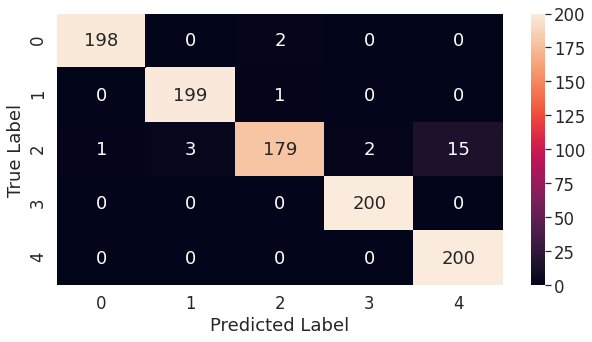

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.4f" %(acc*100))
print(classification_report(flat_true_labels, flat_prediction))

f, ax = plt.subplots(figsize=(10,5))
sns.set(font_scale=1.5)
sns.heatmap(confusion_matrix(flat_true_labels, flat_prediction), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()